In [1]:
import sklearn.preprocessing
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import os
import pandas as pd
import numpy as np
from tsfresh import extract_features
from sklearn.model_selection import train_test_split
from scipy import signal
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
import matplotlib.pyplot as plt

PATH='data'

c:\Users\11985\anaconda3\envs\scoliosis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\11985\anaconda3\envs\scoliosis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
class SensorData(Dataset):
    def __init__(self, train, path=PATH):
        self.train = train
        data = []
        for filepath, dirnames, filenames in os.walk(path):
            for file in filenames:
                data_path = os.path.join(filepath,file)
                df = pd.read_excel(data_path, names=['time','channel1','channel2','channel3','channel4','channel5','channel6'], header=0)
                if np.sum(np.sum(df=='--')) != 0 :
                    continue
                for channel in ['channel1','channel2','channel3','channel4','channel5','channel6']:
                    b, a  =   signal.butter( 8 , [ 0.2 , 0.8 ],  'bandstop' )
                    df[channel] = signal.filtfilt(b, a, df[channel])
                df.insert(loc=1, column='id',value=len(data))
                data.append(df)
        df = data[0]
        for i , dataframe in enumerate(data[1:]):
            df = pd.concat([df, dataframe])
        df = df.fillna(500)
        extraction_settings = ComprehensiveFCParameters()
        X = extract_features(df, column_id='id', column_sort='time', default_fc_parameters=extraction_settings, impute_function=impute)
        # 标准化
        X = sklearn.preprocessing.scale(X)
        # print(X.shape)
        y = pd.Series(['4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '1',
                       '1', '1', '4', '4', '4', '4', '4', '4', '4', '2', '2', '4', '4', '4', '4', '4', '4',
                       '4', '3', '3', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
        
        # y.index = X.index
        X_full_train, X_full_test, y_train, y_test = train_test_split(X, y, test_size=.2)
        print(y_train.values)
        if train:
            self.signals = torch.from_numpy(X_full_train)
            self.labels = torch.from_numpy(y_train.values.astype(np.int16))
        else:
            self.signals = torch.from_numpy(X_full_test)
            self.labels = torch.from_numpy(y_test.values.astype(np.int16))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        signal = self.signals[item]
        label = self.labels[item]
        return signal, label

class DataLoader(object):
    def __init__(self, batch_size=1, is_train=True):
        self.batch_size = batch_size
        self.istrain = is_train

        if is_train:
            self.data = SensorData(train=True)
        else:
            self.data = SensorData(train=False)

    def get_data(self):
        if self.istrain:
            dataloader = torch.utils.data.DataLoader(self.data, batch_size=self.batch_size, shuffle=True)
        else:
            dataloader = torch.utils.data.DataLoader(self.data, batch_size=1, shuffle=False)
        return dataloader

train_loader = DataLoader(batch_size=1, is_train=True)
train_data = train_loader.get_data()
test_loader = DataLoader(is_train=False)
test_data = test_loader.get_data()
print(test_loader.data.labels)

Feature Extraction: 100%|██████████| 39/39 [00:21<00:00,  1.83it/s]
c:\Users\11985\anaconda3\envs\scoliosis\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


['4' '1' '0' '1' '4' '0' '4' '0' '4' '0' '0' '4' '4' '2' '4' '0' '0' '4'
 '4' '4' '0' '0' '4' '4' '4' '0' '4' '4' '4' '0' '0' '4' '4' '4' '4' '3'
 '0' '0' '3' '4' '4' '0' '0' '0' '4' '2']


Feature Extraction: 100%|██████████| 39/39 [00:21<00:00,  1.82it/s]


['4' '4' '0' '4' '0' '0' '0' '4' '4' '4' '0' '4' '4' '0' '0' '4' '0' '4'
 '4' '4' '0' '4' '1' '1' '4' '1' '4' '3' '4' '0' '4' '4' '4' '1' '4' '0'
 '0' '1' '0' '2' '4' '0' '3' '4' '4' '4']


c:\Users\11985\anaconda3\envs\scoliosis\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [3]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()

        self.fc1 = nn.Linear(4722,2000)
        self.re1 = nn.ReLU()
        self.fc2 = nn.Linear(2000,1000)
        self.re2 = nn.ReLU()
        self.fc3 = nn.Linear(1000,100)
        self.re3 = nn.ReLU()
        self.fc4 = nn.Linear(100,5)

    def forward(self, input):
        x = self.fc1(input)
        x = self.re1(x)
        x = self.fc2(x)
        x = self.re2(x)
        x = self.fc3(x)
        x = self.re3(x)
        x = self.fc4(x)
        

        return x


training ...
Epoch: 0 
Train : [45/46 (98%)]	Train_loss: 0.000177 	Accuracy:36/46(78)
Test : Average loss: 0.2924	Accuracy: 11/12 (92%)

Epoch: 1 
Train : [45/46 (98%)]	Train_loss: 0.000000 	Accuracy:38/46(83)
Test : Average loss: 0.3730	Accuracy: 11/12 (92%)

Epoch: 2 
Train : [45/46 (98%)]	Train_loss: 0.986033 	Accuracy:39/46(85)
Test : Average loss: 0.1943	Accuracy: 11/12 (92%)

Epoch: 3 
Train : [45/46 (98%)]	Train_loss: 0.000000 	Accuracy:41/46(89)
Test : Average loss: 0.2221	Accuracy: 11/12 (92%)

Epoch: 4 
Train : [45/46 (98%)]	Train_loss: 0.001404 	Accuracy:41/46(89)
Test : Average loss: 0.0559	Accuracy: 12/12 (100%)

Epoch: 5 
Train : [45/46 (98%)]	Train_loss: 0.000000 	Accuracy:45/46(98)
Test : Average loss: 0.0041	Accuracy: 12/12 (100%)

Epoch: 6 
Train : [45/46 (98%)]	Train_loss: 0.000000 	Accuracy:45/46(98)
Test : Average loss: 0.0003	Accuracy: 12/12 (100%)

Epoch: 7 
Train : [45/46 (98%)]	Train_loss: 0.000363 	Accuracy:45/46(98)
Test : Average loss: 0.0017	Accuracy: 12/12

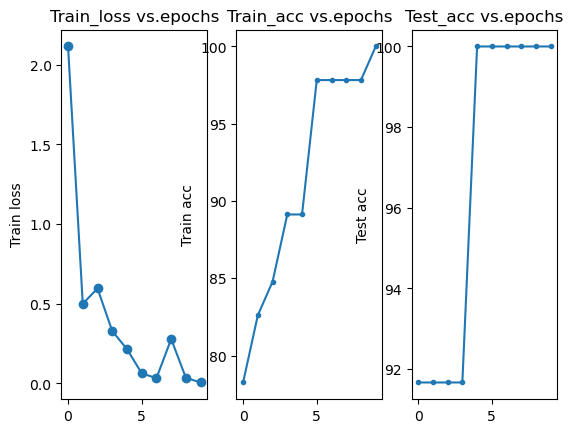

In [10]:
linear_model = LinearNet()
EPOCH=10
optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.001, weight_decay=0.0001)
torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9, last_epoch=-1) 
loss = torch.nn.CrossEntropyLoss()

train_mean_loss_list = []
train_acc_list = []
test_acc_list = []


print('training ...')
bina_lst = []
for epoch in range(EPOCH):
    train_loss_sum = 0
    train_acc_sum = 0
    linear_model.train() 
    for batch_idx, (signals, labels) in enumerate(train_data):
        signals = signals.type(torch.FloatTensor)
        # labels = labels.view([-1,1])
        labels = labels.type(torch.LongTensor)
        optimizer.zero_grad()
        output = linear_model(signals)
        train_loss = loss(output, labels)
        # train_loss.requires_grad_(True)
        train_loss.backward()
        optimizer.step()
        train_loss_sum += train_loss.item()
        train_acc_sum += (output.argmax(dim=1) == labels).sum().item()
        # if(batch_idx+1)%30 == 0: 
    print('Epoch: {} \nTrain : [{}/{} ({:.0f}%)]\tTrain_loss: {:.6f} \tAccuracy:{}/{}({:.0f})'.format(
        epoch, batch_idx * len(signals), len(train_data),
        100. * batch_idx / len(train_data), train_loss.item(),
        train_acc_sum, len(train_data), 100. * train_acc_sum / len(train_data)))
    
    train_mean_loss_list.append(train_loss_sum/batch_idx)
    train_acc_list.append(100. * train_acc_sum/len(train_data))

    linear_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (signals, labels) in enumerate(test_data):
            signals = signals.type(torch.FloatTensor)
            # labels = labels.view([-1,1])
            labels = labels.type(torch.LongTensor)
            output = linear_model(signals)
            test_loss += loss(output, labels).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
    test_loss /= len(test_data)
    print('Test : Average loss: {:.4f}\tAccuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_data),
            100. * correct / len(test_data)))

    test_acc_list.append(100. * correct/len(test_data))

x1 = range(0, EPOCH)
x2 = range(0, EPOCH)
x3 = range(0, EPOCH)
plt.subplot(1, 3, 1) #一行三列的第一列
plt.plot(x1, train_mean_loss_list, 'o-')
plt.title('Train_loss vs.epochs')
plt.ylabel('Train loss')
plt.subplot(1, 3, 2)
plt.plot(x2, train_acc_list, '.-')
plt.title('Train_acc vs.epochs')
plt.ylabel('Train acc')
plt.subplot(1, 3, 3)
plt.plot(x3, test_acc_list, '.-')
plt.title('Test_acc vs.epochs')
plt.ylabel('Test acc')
# plt.savefig("show.jpg")#这一句话一定要放在plt.show()前面
plt.show()



In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=100,
                kernel_size=10,
                stride=1
            ),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(100, 10, 10),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(10,1,10),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(4695,5),
            nn.Sigmoid(),
        )

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)

        return x


training ...
Epoch: 0 
Train : [29/46 (63%)]	Train_loss: 1.606164 	Accuracy:8/46(17)
Test : Average loss: 1.6029	Accuracy: 6/12 (50%)

Epoch: 1 
Train : [29/46 (63%)]	Train_loss: 1.596442 	Accuracy:15/46(33)
Test : Average loss: 1.5972	Accuracy: 6/12 (50%)

Epoch: 2 
Train : [29/46 (63%)]	Train_loss: 1.588374 	Accuracy:15/46(33)
Test : Average loss: 1.5908	Accuracy: 6/12 (50%)

Epoch: 3 
Train : [29/46 (63%)]	Train_loss: 1.588296 	Accuracy:15/46(33)
Test : Average loss: 1.5850	Accuracy: 6/12 (50%)

Epoch: 4 
Train : [29/46 (63%)]	Train_loss: 1.572703 	Accuracy:14/46(30)
Test : Average loss: 1.5791	Accuracy: 6/12 (50%)

Epoch: 5 
Train : [29/46 (63%)]	Train_loss: 1.564866 	Accuracy:16/46(35)
Test : Average loss: 1.5732	Accuracy: 6/12 (50%)

Epoch: 6 
Train : [29/46 (63%)]	Train_loss: 1.570821 	Accuracy:15/46(33)
Test : Average loss: 1.5675	Accuracy: 6/12 (50%)

Epoch: 7 
Train : [29/46 (63%)]	Train_loss: 1.549664 	Accuracy:16/46(35)
Test : Average loss: 1.5617	Accuracy: 6/12 (50%)

Epoc

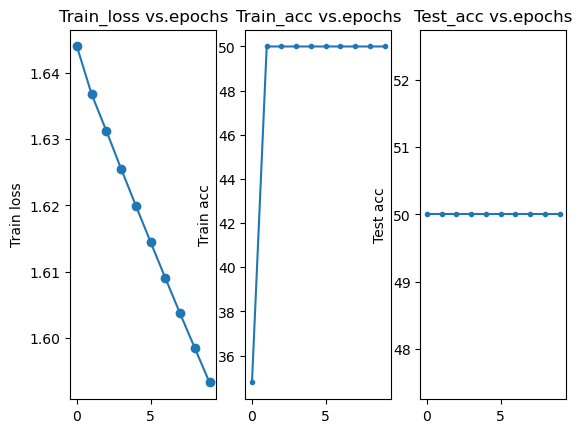

In [9]:
conv_model = CNN()
EPOCH=10
optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001, weight_decay=0.0001)
torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9, last_epoch=-1) 
loss = torch.nn.CrossEntropyLoss()

train_mean_loss_list = []
train_acc_list = []
test_acc_list = []


print('training ...')
bina_lst = []
for epoch in range(EPOCH):
    train_loss_sum = 0
    train_acc_sum = 0
    conv_model.train() 
    for batch_idx, (signals, labels) in enumerate(train_data):
        signals = signals.type(torch.FloatTensor)
        # labels = labels.view([-1,1])
        labels = labels.type(torch.LongTensor)
        optimizer.zero_grad()
        output = conv_model(signals)
        train_loss = loss(output, labels)
        # train_loss.requires_grad_(True)
        train_loss.backward()
        optimizer.step()
        train_loss_sum += train_loss.item()
        train_acc_sum += (output.argmax(dim=1) == labels).sum().item()
        if(batch_idx+1)%30 == 0: 
            print('Epoch: {} \nTrain : [{}/{} ({:.0f}%)]\tTrain_loss: {:.6f} \tAccuracy:{}/{}({:.0f})'.format(
                epoch, batch_idx * len(signals), len(train_data),
                100. * batch_idx / len(train_data), train_loss.item(),
                train_acc_sum, len(train_data), 100. * train_acc_sum / len(train_data)))
    
    train_mean_loss_list.append(train_loss_sum/batch_idx)
    train_acc_list.append(100. * train_acc_sum/len(train_data))

    conv_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (signals, labels) in enumerate(test_data):
            signals = signals.type(torch.FloatTensor)
            # labels = labels.view([-1,1])
            labels = labels.type(torch.LongTensor)
            output = conv_model(signals)
            test_loss += loss(output, labels).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
    test_loss /= len(test_data)
    print('Test : Average loss: {:.4f}\tAccuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_data),
            100. * correct / len(test_data)))

    test_acc_list.append(100. * correct/len(test_data))


    

x1 = range(0, EPOCH)
x2 = range(0, EPOCH)
x3 = range(0, EPOCH)
plt.subplot(1, 3, 1) #一行三列的第一列
plt.plot(x1, train_mean_loss_list, 'o-')
plt.title('Train_loss vs.epochs')
plt.ylabel('Train loss')
plt.subplot(1, 3, 2)
plt.plot(x2, train_acc_list, '.-')
plt.title('Train_acc vs.epochs')
plt.ylabel('Train acc')
plt.subplot(1, 3, 3)
plt.plot(x3, test_acc_list, '.-')
plt.title('Test_acc vs.epochs')
plt.ylabel('Test acc')
# plt.savefig("show.jpg")#这一句话一定要放在plt.show()前面
plt.show()



In [7]:
from torch.nn.utils.rnn import pad_sequence
